Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время);
-  `/datasets/final_steel/`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

## План решения задачи.
### 1. Подготовить данные
* пропущенные значения, что с нимим делать
* есть ли аномальные значения
* какие свойства имеют распределения

### 2. Анализ данных
* какие данные являются целевым признаком
* все ли признаки необходимы для обучения модели
* объединение таблиц (все ли таблицы нужны?)

### 3. Обучение модели
### 4. Выводы

## 1. Подготовка данных

### Электроды

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [3]:
data_arc[data_arc['key']==1]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


***Активная мощность***

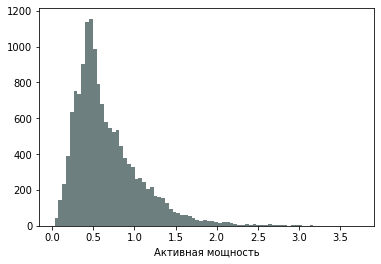

In [5]:
fig, ax = plt.subplots()
ax.hist(data_arc['Активная мощность'],bins = 80, color = '#6E7F80')
ax.set_xlabel('Активная мощность');

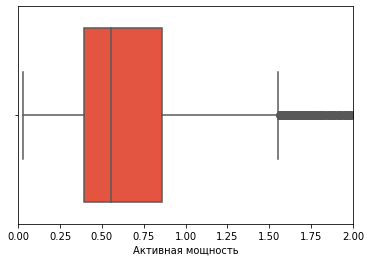

In [6]:
plt.xlim(0, 2)
sns.boxplot(data_arc['Активная мощность'], whis = 1.5, palette = 'CMRmap');

In [7]:
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

In [8]:
iqr = data_arc['Активная мощность'].quantile(0.75) -\
                                data_arc['Активная мощность'].quantile(0.25)
q_3 = data_arc['Активная мощность'].describe()[6]

In [9]:
out = q_3 + 3 * iqr

***Распределение имеет скос вправо, предлагаю избавиться от Активной мощности согласно формуле:***

$$
Q3 + 3 * IQR
$$

In [10]:
data_arc[data_arc['Активная мощность']>out]['Активная мощность'].count()/len(data_arc)

0.006318902930895402

In [11]:
data_arc = data_arc[data_arc['Активная мощность'] < out]

С точки зрения плавления металла, согласен, справочник нам в помощь. А вот сколько тратиться активной и реактивной мощности - адекватность этих данных можно было бы проверить, имея информацию о полной мощности...Почистил, с точки зрения теории выбросов.

----

***Реактивная мощность***

***Есть выброс - в поле Реактивная мощность -715***

In [12]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

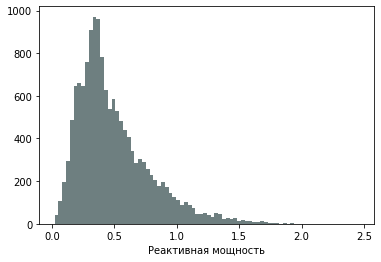

In [13]:
fig, ax = plt.subplots()
ax.hist(data_arc['Реактивная мощность'],
        bins = 80, color = '#6E7F80')
ax.set_xlabel('Реактивная мощность');

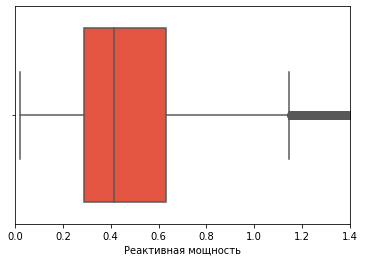

In [14]:
plt.xlim(0, 1.4)
sns.boxplot(data_arc['Реактивная мощность'], whis = 1.5, palette = 'CMRmap');

In [15]:
data_arc['Реактивная мощность'].describe()

count    14781.000000
mean         0.491962
std          0.291208
min          0.020806
25%          0.289519
50%          0.414516
75%          0.631412
max          2.459959
Name: Реактивная мощность, dtype: float64

In [16]:
iqr = data_arc['Реактивная мощность'].quantile(0.75) -\
                            data_arc['Реактивная мощность'].quantile(0.25)
q_3 = data_arc['Реактивная мощность'].describe()[6]

In [17]:
out = q_3 + 3 * iqr

***Распределение имеет скос вправо, предлагаю избавиться от Реактивной мощности согласно формуле:***

$$
Q3 + 3 * IQR
$$

In [18]:
data_arc[data_arc['Реактивная мощность']>out]['Реактивная мощность'].count()/len(data_arc)

0.0027738312698734864

In [19]:
data_arc = data_arc[data_arc['Реактивная мощность'] < out]

In [20]:
data_arc.reset_index(drop=True, inplace = True)

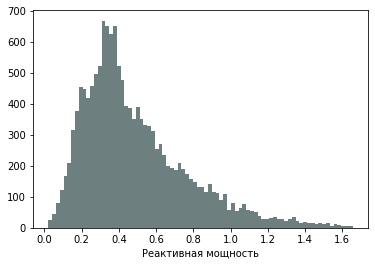

In [21]:
fig, ax = plt.subplots()
ax.hist(data_arc['Реактивная мощность'],
        bins = 80, color = '#6E7F80')
ax.set_xlabel('Реактивная мощность');

In [22]:
data_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


### Cыпучие материалы

In [23]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [24]:
data_bulk[data_bulk['key']==1]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


In [25]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [26]:
data_bulk.drop('key', axis = 1).describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [27]:
bulk_list = data_bulk.drop('key', axis = 1).columns.to_list()
len(bulk_list)

15

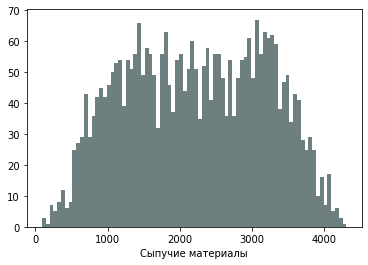

In [28]:
fig, ax = plt.subplots()
ax.hist(data_bulk.sum(axis=1),
        bins = 80, 
        color = '#6E7F80')
ax.set_xlabel('Cыпучие материалы');

***Нет объектов со всеми NaN. Пропущенные значения стоит заменить нулями - сыпучие материалы на этих партиях не добавлялись***

In [29]:
data_bulk.fillna(0, inplace = True)

### Cыпучие материалы (время)

In [30]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [31]:
data_bulk_time[data_bulk_time['key']==1]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52


In [32]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


***NaN заполним значением UNK***

### Продувка сплава газом

In [33]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [34]:
data_gas[data_gas['key']==1]

,key,Газ 1
0,1,29.749986


In [35]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


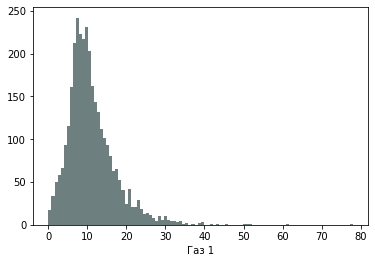

In [36]:
fig, ax = plt.subplots()
ax.hist(data_gas['Газ 1'],
        bins = 100, 
        color = '#6E7F80')
ax.set_xlabel('Газ 1');

In [37]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

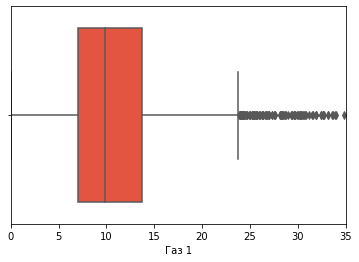

In [38]:
plt.xlim(0, 35)
sns.boxplot(data_gas['Газ 1'], whis = 1.5, palette = 'CMRmap');

***Распределение имеет скос вправо, есть выбросы (77 например) предлагаю избавиться от Газа согласно формуле:***

$$
Q3 + 3 * IQR
$$

In [39]:
iqr = data_gas['Газ 1'].quantile(0.75) -\
                            data_gas['Газ 1'].quantile(0.25)
q_3 = data_gas['Газ 1'].describe()[6]

In [40]:
out = q_3 + 3 * iqr

In [41]:
data_gas[data_gas['Газ 1']>out]['Газ 1'].count()/len(data_gas)

0.005557270762581044

In [42]:
data_gas = data_gas[data_gas['Газ 1'] < out]

### Температура

In [43]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [44]:
data_temp[data_temp['key']==1]

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [45]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


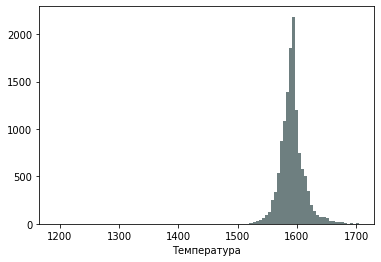

In [46]:
fig, ax = plt.subplots()
ax.hist(data_temp['Температура'],bins = 100, color = '#6E7F80')
ax.set_xlabel('Температура');

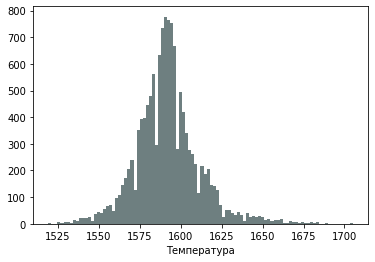

In [47]:
fig, ax = plt.subplots()
ax.hist(data_temp[data_temp['Температура'] > 1400]['Температура'],bins = 100, color = '#6E7F80')
ax.set_xlabel('Температура');

***Есть пропуски в целевом признаке, эти строки необходимо удалить. Необходимо убрать выбросы, температуру меньше 1400, а также выбросы по формуле:***

$$
Q3 + 3 * IQR
$$

In [48]:
data_temp.dropna(inplace = True)

In [49]:
iqr = data_temp['Температура'].quantile(0.75) -\
                                data_temp['Температура'].quantile(0.25)
q_3 = data_temp['Температура'].describe()[6]

In [50]:
out = q_3 + 3 * iqr

In [51]:
data_temp = data_temp[data_temp['Температура'] > 1400]

In [52]:
data_temp = data_temp[data_temp['Температура'] < out]

In [53]:
data_temp.reset_index(drop=True, inplace = True)

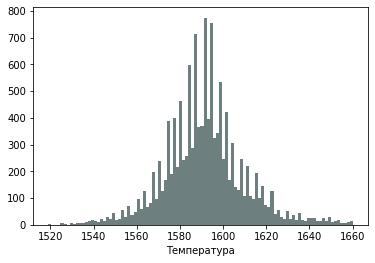

In [54]:
fig, ax = plt.subplots()
ax.hist(data_temp['Температура'],bins = 100, color = '#6E7F80')
ax.set_xlabel('Температура');

Да, тоже обратил внимание где-то 4 измерения, где-то 5. Решил, что раз итеративный подход, следовательно при производство и смешивании и добавлении компонентов удалось раньше достигнуть нужной температуры. Почищу едничные измерения.

Тут все немного сложнее, есть строки, где при равных температурах, количество итераций больше единицы, вот список:

In [55]:
pd.concat([data_temp[data_temp['key']==key]\
     for key in data_temp['key'].unique()
            if ([data_temp[data_temp['key']==key].iloc[0,2]]==\
                data_temp[data_temp['key']==key].iloc[-1,2]) &\
           (len(data_temp[data_temp['key']==key]) > 1)]).head(10)

,key,Время замера,Температура
358,63,2019-05-05 15:53:11,1580.0
359,63,2019-05-05 16:08:15,1584.0
360,63,2019-05-05 16:12:40,1578.0
361,63,2019-05-05 16:15:32,1580.0
1091,197,2019-05-10 16:31:15,1582.0
1092,197,2019-05-10 16:31:59,1573.0
1093,197,2019-05-10 16:36:49,1578.0
1094,197,2019-05-10 16:37:33,1577.0
1095,197,2019-05-10 16:40:40,1582.0
1456,262,2019-05-13 04:42:00,1596.0


Значит дело не только в нужной температуре, но и в добавляемых компонентах. Лучше отталкиваться от длины партии:

In [56]:
data_temp = pd.concat([data_temp.loc[(data_temp['key'] == key).values, ['key', 'Время замера', 'Температура']]\
     for key in data_temp['key'].unique()
            if len(data_temp[data_temp['key']==key]) > 1])

### Проволочные материалы

In [57]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [58]:
data_wire[data_wire['key']==1]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [60]:
data_wire.drop('key', axis = 1).describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


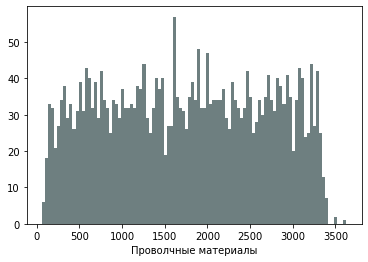

In [61]:
fig, ax = plt.subplots()
ax.hist(data_wire.sum(axis=1),bins = 100, color = '#6E7F80')
ax.set_xlabel('Проволчные материалы');

***Нет объектов со всеми NaN. Пропущенные значения стоит заменить нулями - проволочные материалы на этих партиях не добавлялись***

In [62]:
data_wire.fillna(0, inplace = True)

### Проволочные материалы (время)

In [63]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [64]:
data_wire_time[data_wire_time['key']==1]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


***NaN заполним значением UNK***

In [66]:
data_wire_time.fillna('UNK', inplace = True)

Сделал по формуле

---

## 2. Анализ данных

***Согласно описанию цикла обработки температуру меняют, добавляют легирующие материалы и продувают сплав инертным газом и перемешивают - такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. Следовательно, для обучения нашей модели необходимо в качестве целевого признака брать финальные показания температуры, а первичные показания - в качестве входных данных. Кроме того, в данных по электродам следует рассчитать полную мощность, а данные о подаче материалов, стоит оценивать исходя из их корреляций и ценности при обучении модели.***

***Отделим первичную температуру от финальной***

In [67]:
compreh_temp =[[data_temp[data_temp['key']==key].iloc[0,0],
               data_temp[data_temp['key']==key].iloc[0,2],
               data_temp[data_temp['key']==key].iloc[-1,2]]
            for key in data_temp['key'].unique()]

In [68]:
new_data_temp = pd.DataFrame(compreh_temp,columns = 
                        ['key','Первичная температура', 'Финальная температура'])

In [69]:
new_data_temp.set_index(keys = 'key', drop=True, inplace = True)

***Есть очень сильная корреляция между парами Активная мощность/Реактивная мощность (практически, прямая зависимость) - мультиколлинераность - от нее необходимо избавляться***

In [70]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'], method = 'spearman')

0.9686333838317844

***Считаем полную мощность для финальных показателей по формуле:***

$$S = \sqrt{P^{2} +  Q^{2}}$$

In [71]:
full_power =\
pd.DataFrame([[data_arc[data_arc['key']==key].iloc[0,0],
            np.sqrt(np.sum(data_arc[data_arc['key']==key].iloc[:,3])**2 +\
            np.sum(data_arc[data_arc['key']==1].iloc[:,4])**2)]
            for key in data_arc['key'].unique()], columns = ['key','Полная мощность'])

In [72]:
full_power.set_index(['key'],inplace=True, drop = True)

***Так как за целевой признак приняли финальные показания температуры, попробуем подать модели на вход сыпучие и проволочным материалам как по каждому bulk'у и wire, так и сумму их по каждой партии.***

***В итоге, модель показывает лучшие результаты, если подавать на вход сумму по всем проволочным материалам (так проволное материалы, имеют одинаковый состав и структуру , тогда как сыпучие материалам необходимо подавать по отдельности (разный химический состав).***

In [73]:
data_wire['wire_all'] = data_wire.sum(axis=1)

***Объединение таблиц***

In [74]:
data_bulk.set_index(['key'],inplace=True)
data_gas.set_index(['key'],inplace=True)
data_wire.set_index(['key'],inplace=True)

In [75]:
new_data_temp = new_data_temp.join(full_power, on = 'key', how = 'inner')

In [76]:
new_data_temp = new_data_temp.join(data_bulk,
                                   how = 'inner')

In [77]:
new_data_temp = new_data_temp.join(data_gas,how = 'inner')

In [78]:
data = new_data_temp.join(data_wire['wire_all'],
                          how = 'inner')

In [79]:
data.head(3)

,Первичная температура,Финальная температура,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,wire_all
key,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5.824889,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,61.059998
2,1581.0,1602.0,4.410372,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,98.052315
3,1596.0,1599.0,4.063632,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,94.160157


Вслед за температурой я решил разбить и мощности (первичная и финальная), затем почитав про реактивную мощность при изготовление металла, решил от нее избавиться. Вот: ***Мощность, которая постоянно перетекает туда и обратно между источником и нагрузкой, известна как реактивная.*** Но, так как еще и наблюдается проблема  мультиколлинеарности, согласен, следует рассчитать сразу полную мощность по формуле.

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313 entries, 1 to 2499
Data columns (total 20 columns):
Первичная температура    2313 non-null float64
Финальная температура    2313 non-null float64
Полная мощность          2313 non-null float64
Bulk 1                   2313 non-null float64
Bulk 2                   2313 non-null float64
Bulk 3                   2313 non-null float64
Bulk 4                   2313 non-null float64
Bulk 5                   2313 non-null float64
Bulk 6                   2313 non-null float64
Bulk 7                   2313 non-null float64
Bulk 8                   2313 non-null float64
Bulk 9                   2313 non-null float64
Bulk 10                  2313 non-null float64
Bulk 11                  2313 non-null float64
Bulk 12                  2313 non-null float64
Bulk 13                  2313 non-null float64
Bulk 14                  2313 non-null float64
Bulk 15                  2313 non-null float64
Газ 1                    2313 non-null float64


***Переведем признаки на латиницу***

In [81]:
data.rename({'Финальная температура': 'final_temp','Первичная температура': 'first_temp',
           'Газ 1': 'Gas 1', 'Полная мощность' : 'Full_pow'}, axis=1, inplace = True)

In [82]:
corr = data.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,first_temp,final_temp,Full_pow,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Gas 1,wire_all
first_temp,1,0.31,-0.46,0.057,0.094,-0.11,0.19,0.03,-0.17,0.021,-0.014,-0.021,0.035,-0.097,-0.073,0.026,-0.16,-0.062,0.027,-0.017
final_temp,0.31,1,0.24,-0.05,-0.0073,-0.036,0.24,-0.03,-0.26,-0.059,-0.03,-0.0085,0.049,-0.12,0.24,-0.016,0.06,0.23,0.043,-0.091
Full_pow,-0.46,0.24,1,0.071,0.012,0.12,-0.061,0.046,0.11,0.017,-0.014,0.018,-0.0072,0.033,0.42,0.036,0.42,0.32,0.33,-0.034
Bulk 1,0.057,-0.05,0.071,1,0.16,-0.0051,0.044,0.045,0.003,0.13,-0.0062,-0.021,-0.025,-0.044,0.26,-0.0041,0.19,0.038,0.14,-0.057
Bulk 2,0.094,-0.0073,0.012,0.16,1,-0.05,0.044,0.43,-0.03,0.63,-0.0013,-0.0043,-0.016,0.015,-0.085,-0.0049,-0.096,-0.08,0.091,0.0049
Bulk 3,-0.11,-0.036,0.12,-0.0051,-0.05,1,-0.38,-0.03,-0.055,-0.053,0.028,0.034,-0.068,-0.058,0.016,-0.022,0.011,-0.016,0.06,0.037
Bulk 4,0.19,0.24,-0.061,0.044,0.044,-0.38,1,0.0079,-0.33,0.027,-0.015,-0.0084,-0.042,-0.17,0.098,0.0033,-0.12,0.086,-0.016,-0.015
Bulk 5,0.03,-0.03,0.046,0.045,0.43,-0.03,0.0079,1,0.037,0.27,-0.0031,-0.01,-0.038,-0.022,-0.093,-0.011,-0.045,-0.065,0.054,0.034
Bulk 6,-0.17,-0.26,0.11,0.003,-0.03,-0.055,-0.33,0.037,1,-0.017,-0.0099,-0.033,-0.12,0.35,-0.14,0.044,0.18,-0.11,0.11,0.015
Bulk 7,0.021,-0.059,0.017,0.13,0.63,-0.053,0.027,0.27,-0.017,1,-0.0014,-0.0046,-0.017,0.013,-0.074,-0.0051,-0.085,-0.067,0.049,0.046


***Мультиколлинеарность просматривается также между признаками Bulk 2/Bulk 7, а также Bulk 12/Bulk 15. Избавимся от Bulk7 и Bulk15***

In [83]:
data.drop(['Bulk 7', 'Bulk 15'],
axis=1, inplace=True)

###  Исходя из анализа ценности признаков для модели избавимся от Bulk 8:

- first_temp	18.464453
- Bulk 12	15.082309
- wire_all	12.895305
- Bulk 14	12.383834
- Gas 1	9.404831
- Bulk 6	8.947279
- Bulk 1	5.569842
- Bulk 3	4.712614
- Bulk 4	4.643679
- Bulk 11	1.897425
- Bulk 10	1.716477
- Full_pow	1.687810
- Bulk 2	1.601279
- Bulk 5	0.672267
- Bulk 13	0.254528
- Bulk 9	0.066069
- Bulk 8	0.000000

In [84]:
data.drop(['Bulk 8'],
axis=1, inplace=True)

## 3. Обучение модели

In [85]:
features = data.drop(['final_temp'], axis = 1)
target = data['final_temp']

In [86]:
features_train,features_test,target_train,target_test =\
                                train_test_split(features, target, test_size=0.2, random_state=12345)

In [87]:
features_train.shape, features_test.shape

((1850, 16), (463, 16))

---
### BasLine (LinearRegression)

In [88]:
linear_model = LinearRegression()
linear_model.fit(features_train,target_train)
prediction = linear_model.predict(features_test)
mean_absolute_error(target_test,prediction)

6.403761787757173

### CatBoost

***Так как данных для обучения немного, принято решения воспользоваться алгоритмами градиентного бустинга CatBoost и LightGBM***

In [89]:
train_pool = Pool(data=features_train, label=target_train)
test_pool = Pool(data=features_test, label=target_test)
catb = CatBoostRegressor(loss_function = 'MAE',iterations=2000,eval_metric = 'MAE')

In [90]:
catb.fit(
        train_pool,
        eval_set=test_pool,
        verbose=1000)

0:	learn: 7.8159774	test: 8.3566945	best: 8.3566945 (0)	total: 49.9ms	remaining: 1m 39s
1000:	learn: 3.8576573	test: 6.0983471	best: 6.0982904 (992)	total: 17.8s	remaining: 17.7s
1999:	learn: 3.3204729	test: 6.1535133	best: 6.0962928 (1005)	total: 35.5s	remaining: 0us

bestTest = 6.096292813
bestIteration = 1005

Shrink model to first 1006 iterations.


In [91]:
pd.DataFrame(pd.Series(catb.get_feature_importance(), 
                       features.columns)).sort_values(by = 0, ascending = False)

,0
Full_pow,24.365022
first_temp,23.149656
Bulk 6,9.225608
Bulk 12,7.771100
Gas 1,7.728922
wire_all,7.337712
Bulk 14,6.590284
Bulk 3,4.195922
Bulk 1,3.369955
Bulk 4,2.949256


In [92]:
catb_prediction = catb.predict(features_test)
mean_absolute_error(target_test,catb_prediction)

6.096293812635665

In [93]:
catb.get_params()

{'iterations': 2000, 'loss_function': 'MAE', 'eval_metric': 'MAE'}

In [94]:
catb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Exact',
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.1000000015,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'approx_on_full_history': False,
 'subsample': 0.8000000119,
 'use_best_model': True,
 'random_seed': 0,
 'depth': 6,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 254,
 'classes_count': 0,
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'loss_function': 'MAE',
 'learning_rate': 0.02999999933,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'MVS',
 'permutation_count': 4}

### LightGBM

In [95]:
lgb = LGBMRegressor()

param_grid = {'n_estimators': [30,45,60], 
            'max_depth': [5,6,7],
            'num_leaves' : [28,29,30]}

grid_lgb = GridSearchCV(lgb, param_grid, cv=5, scoring = 'neg_mean_absolute_error') 


In [96]:
grid_lgb.fit(features_train,target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 6, 7], 'n_estimators': [30, 45, 60],
                         'num_leaves': [28, 29, 30]},
             pre_dispatch='2*n_jobs',

In [97]:
grid_lgb.best_params_

{'max_depth': 6, 'n_estimators': 45, 'num_leaves': 28}

In [98]:
np.abs(grid_lgb.score(features_test, target_test))

6.393992756121464

## 4. Отчет по выполненной работе(выводы):
### Удалось выполнить все пункты согласно примерного плана решения задачи. 
### А именно:  
***1. Подготовка данных:***
 - обработаны пропуски (в целевом признаке удалены, в числовых данных заменены на 0, в object значением 'UNK')
 - из данных удалены аномалные значения, очищены данные, опираясь на формулу теории выбросов
 - практически все признаки имели распределения с положительным сдвигом (данные очищены - это считанные проценты от всего набора данных)
 
***2. Анализ данных***
 - выявлено - целевым признаком являются финальные показатели температуры
 - есть партии с одной итерацией температуры при изготовлении металла - от них решено было избавиться
 - согласно формуле посчитана полная мощность, а также просуммированы данные по проволочным материалам
 - так как целевым признаком является финальная температура, принято решение отказаться от временной составляющей в наших данных, не учитывались таблицы, содержащие время добавления сыпучих и проволчных материалов. 
 - в ходе анализа признаков обнаружена мультиколлинеарность между парами Активная/Реактивная мощности, Bulk 2/Bulk7 и Bulk12/Bulk 15 - устранено.
 - для оценки важности признаков для обучения модели был использован метод feature_importance модели CatBoost - отказались от 'Bulk 8'

 
***3. Обучение***
 - Использовав для обучения алгоритм CatBoost cо следующимим гиперпараметрами {'iterations': 2000,'l2_leaf_reg': 3,'model_size_reg': 0.5, 'subsample': 0.8000000119,'depth': 6,'learning_rate': 0.02999999933, 'score_function': 'Cosine', 'bootstrap_type': 'MVS'}, удалось добиться показателя MAE на тестовой выборке равным 6.09, что соответствует поставленному заданию.

## Примерный план решения задачи.
### 1. Подготовить данные
* пропущенные значения, что с нимим делать
* есть ли аномальные значения
* какие свойства имеют распределения

### 2. Анализ данных
* какие данные являются целевым признаком
* все ли признаки необходимы для обучения модели
* объединение таблиц (все ли таблицы нужны?)

### 3. Обучение модели
### 4. Выводы